In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

In [3]:
from pathlib import Path
from PIL import Image
import numpy as np
import trimesh
import pyrender
from ipywidgets import interact
from scipy.spatial.transform import Rotation

In [4]:
from dimo_loader import DimoLoader

# DIMO viewer

In [5]:
ds_path = Path('/home/peter/Projects/Baekeland/keylines/data/raw/keylines/dimo_blocks_small/dimo_small')

In [6]:
dimo_loader = DimoLoader()
dimo_ds = dimo_loader.load(ds_path, cameras=['real_jaigo', 'real_d415', 'real_l515', 'real_mvbluefox', 'sim_jaigo'])

Loading real_jaigo
Loading real_d415
Loading real_l515
Loading real_mvbluefox
Loading sim_jaigo


## Rendering setup

In [14]:
def t_from_xyz(x=0., y=0., z=0.):
    t = np.eye(4, 4)
    t[:3, 3] = [x, y, z]
    return t

# OpenCV (dimo) -> OpenGL (pyrender) conversion
def transform_viewpoint(viewpoint):
    rotate_x_180 = np.eye(4, 4)
    rotate_x_180[:3, :3] = Rotation.from_euler('x', [180.], degrees=True).as_matrix()
    return viewpoint @ rotate_x_180

def setup_renderer(im_size):
    im_w = im_size[0]
    im_h = im_size[1]
    p_renderer = pyrender.OffscreenRenderer(im_w, im_h)
    p_scene = pyrender.Scene(bg_color=[0., 0., 0., 0.])
    return p_renderer, p_scene

def update_camera(camera, fx, fy, cx, cy):
    camera.fx = fx
    camera.fy = fy
    camera.cx = cx
    camera.cy = cy

def add_lights(p_scene):
    p_scene.ambient_light = [0.5, 0.5, 0.5]
    light = pyrender.DirectionalLight(color=[1., 1., 1.], intensity=5.)
    light = p_scene.add(light, pose=transform_viewpoint(t_from_xyz(z=500.)))

def prepare_image(image, models, p_scene):
    p_scene.clear()
    add_lights(p_scene)
    K = image['camera']['K']
    fx, fy, cx, cy = K[0, 0], K[1, 1], K[0, 2], K[1, 2]
    p_camera = p_scene.add(pyrender.IntrinsicsCamera(fx, fy, cx, cy, 0.05, 1000))
    p_scene.set_pose(p_camera, transform_viewpoint(t_from_xyz()))
    for obj in image['objects']:
        mesh = models[obj['id']].copy()
        mesh.visual.vertex_colors = trimesh.visual.color.random_color()
        o = p_scene.add(pyrender.Mesh.from_trimesh(mesh))
        obj_pose = obj['model_2cam']
        o.translation =  obj_pose[:3, 3].copy()
        o.rotation = Rotation.from_matrix(obj_pose[:3, :3]).as_quat()
        
def load_image(path):
    image = Image.open(path)
    image = image.convert('RGBA')
    return image

In [15]:
def load_models(models):
    return {model['id']: trimesh.load(model['cad']) for model in models}

{'light': 0, 'carrier': 0, 'parts': 1, 'viewpoint': 0}


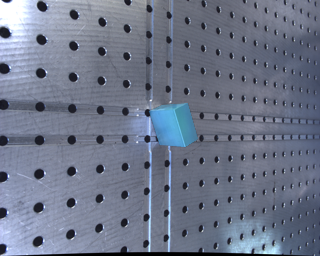

In [16]:
cameras = [c for c in dimo_ds.keys() if c != 'models']
dimo_models = [model for model in dimo_ds['models'] if model['id'] < 100]
models = load_models(dimo_models)

try:
    p_renderer.delete()
except:
    pass

def show_camera(camera):
    scenes = dimo_ds[camera]
    first_img = load_image(scenes[0]['images'][0]['path'])
    
    p_renderer, p_scene = setup_renderer(first_img.size)
    
    def show_scene(i):
        scene = scenes[i]
        
        def show_image(j):
            prepare_image(scene['images'][j], models, p_scene)
            img = load_image(scene['images'][j]['path'])
            print(scene['images'][j]['scene_info'])
            rgba, _ = p_renderer.render(p_scene, flags=pyrender.RenderFlags.RGBA) 
            overlay = Image.fromarray(rgba)
            composite = Image.alpha_composite(img, overlay)
            blended = Image.blend(img, composite, alpha=0.4)
            blended.thumbnail((600, 600))
            display(blended)
            
        interact(show_image, j=range(len(scene['images'])))
    
    interact(show_scene, i=range(len(scenes)))

interact(show_camera, camera=cameras);